In this example we will perform an analysis for the app focusing on investigation why people remove app. Our negative target even in this case will be "app_remove".

In [102]:
from retentioneering import init_config
import pandas as pd


init_config(
    experiments_folder='mobile-app', # folder for saving experiment results: graph visualization, heatmaps and etc.
    index_col='user_pseudo_id', # column by which we split users / sessions / whatever
    event_col='event_name', # column that describes event
    event_time_col='event_timestamp', # column that describes timestamp of event
    positive_target_event='not_remove', # name of positive target event
    pos_target_definition={},
    negative_target_event='app_remove', # name of positive target event
)

/Users/anatolyzaytsev/.local/lib/python3.7/site-packages/retentioneering-0.4.1-py3.7.egg/retentioneering/core/utils.py:53: UserWarning: registration of accessor <class 'retentioneering.core.utils.init_config.<locals>.RetentioneeringTrajectory'> under name 'trajectory' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  class RetentioneeringTrajectory(BaseTrajectory):
/Users/anatolyzaytsev/.local/lib/python3.7/site-packages/retentioneering-0.4.1-py3.7.egg/retentioneering/core/utils.py:60: UserWarning: registration of accessor <class 'retentioneering.core.utils.init_config.<locals>.RetentioneeringDataset'> under name 'retention' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  class RetentioneeringDataset(BaseDataset):


In [73]:
data = pd.read_csv('data/mobile-app-data.zip')
data = data.sort_values('event_timestamp')
# problems with timestamp order
data.event_timestamp *= 1000
# adds positive event
data = data.retention.prepare()

Firstly, we need to filter and aggregate events.

To remove specific event simply click on the blue checkbox for selected event. To aggregare group of events to single parent event click on the smaller gray checkbox near parent event.

Now let's remove system events, screen_view, os events, user_engagement, from app we need just app_remove, 

In [74]:
data.retention.show_tree_selector()

After that you need to download created filter with using "Download Filter" link.

Now you can use this filter using next chunk.

Below you can upload filter file we created for the cases we illustrate later in this notebook

In [75]:
data = data.retention.use_tree_filter('filter_list.json')

Lets split data into sessions

In [76]:
data.retention.split_sessions(by_event='session_start')
data['user_session'] = data.user_pseudo_id + data.session.astype(int).astype(str)

# Analysis

## Step matrix

In [98]:
init_config(
    experiments_folder='mobile-app', # folder for saving experiment results: graph visualization, heatmaps and etc.
    index_col='user_pseudo_id', # column by which we split users / sessions / whatever
    event_col='event_name', # column that describes event
    event_time_col='event_timestamp', # column that describes timestamp of event
    positive_target_event='test_test_test', # name of positive target event
    pos_target_definition={},
    negative_target_event='dandd', # name of positive target event
)


data = pd.read_csv('data/mobile-app-data.zip')
data = data.sort_values('event_timestamp')
# problems with timestamp order
data.event_timestamp *= 1000
# adds positive event
data = data.retention.prepare()

data = data.retention.use_tree_filter('filter_list_2.json')

data.retention.split_sessions(by_event='session_start')
data['user_session'] = data.user_pseudo_id + data.session.astype(int).astype(str)

/Users/anatolyzaytsev/.local/lib/python3.7/site-packages/retentioneering-0.4.1-py3.7.egg/retentioneering/core/utils.py:53: UserWarning: registration of accessor <class 'retentioneering.core.utils.init_config.<locals>.RetentioneeringTrajectory'> under name 'trajectory' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  class RetentioneeringTrajectory(BaseTrajectory):
/Users/anatolyzaytsev/.local/lib/python3.7/site-packages/retentioneering-0.4.1-py3.7.egg/retentioneering/core/utils.py:60: UserWarning: registration of accessor <class 'retentioneering.core.utils.init_config.<locals>.RetentioneeringDataset'> under name 'retention' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  class RetentioneeringDataset(BaseDataset):


In [99]:
len(data.retention.get_positive_users())

28818

In [100]:
len(data)

2042471

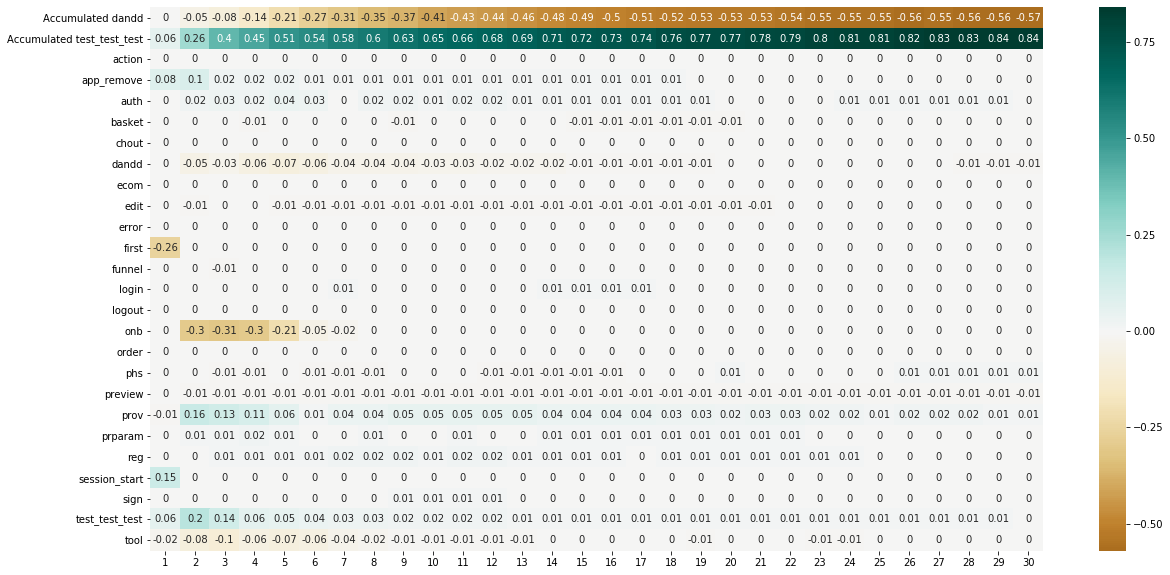

In [101]:
f = data.retention.create_filter(index_col='user_session')
data.retention.get_step_matrix_difference(f, index_col='user_session');

From previous plot we can see that in sessions with removed app, users significantly slows down on onboarding (onb group) and on catalogue (prov group).

This is our first hypothesis about app problems.

## Clustering

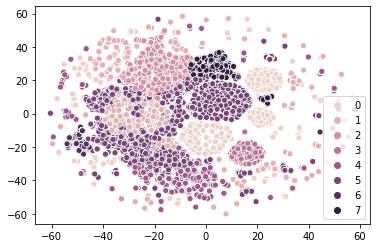

In [7]:
data.retention.learn_tsne(index_col='user_session', plot_type='clusters');

We can choose cluster from center and visualize it

We can see problems with catalogue for zero cluster: a lot of users move from app after first prov event.

In [8]:
data.retention.get_clusters(index_col='user_session');

In [9]:
(data
 .retention
 .filter_cluster(1, index_col='user_session')
 .retention
 .plot_graph(index_col='user_session', thresh=0.05))

/anaconda3/lib/python3.7/site-packages/networkx/drawing/layout.py:923: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  pos = np.row_stack((pos[x] for x in node_list))


Selection process involves multiple steps were users edit their selected products and select different kind of options (node "param"). Users can do this without authorization. But after they add selected and customized products to cart they are asked to authorize.

In this cluster we can clearly see the problem with autorization: after authorization we need to return to catalogue (node "prov") and start selection and customization process all over again (node "prparam").

We can see from graph that there is no way to return after authorization to previous step in catalogue (no edge from "auth" to "prparam").

This is a problem in app: authorization brokes user trajectory, so user should return in the beginning.

We can see problems with detailed events via `dump_event_col` column.

In [10]:
(data
 .retention
 .filter_cluster(1, index_col='user_session')
 .retention
 .plot_graph(index_col='user_session', cols=['dump_event_col', 'dump_event_col_shift'], thresh=0.08, width=800, height=800))

This graph can support our hypothesis about bad catalogue organization with `prov_click_category_other` event. We can see that users often remove app after this event, wich redirects users to web-page. It's clear example of not optimal app organization where web-page link cannibiling users from mobile app.

# Classifier

In [64]:
#train/test split
data_rnd = data.sample(frac=1)
data_train = data_rnd[:round(len(data)*0.8)]
data_test = data_rnd[round(len(data)*0.8)+1:]

#create model on train
model = data_train.retention.create_model()

#extract features from train
features_train = data_train.retention.extract_features(ngram_range=(1,2))

#extract featiures from test
features_test = data_test.retention.extract_features(ngram_range=(1,2))

#add missing features
features_test = features_test.loc[:, features_train.columns.tolist()].fillna(0)

#add targets to test
target = features_test.index.isin(data_test.retention.get_positive_users())

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/anatolyzaytsev/.local/lib/python3.7/site-packages/pandas-0.24.2-py3.7-macosx-10.9-x86_64.egg/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [67]:
data_test.head()

,event_timestamp,event_name,user_pseudo_id,dump_event_col,session,user_session
1610571,2019-04-01 18:38:17.638028,phs,75489dff84000f93521067b63aa31cbb,phs_swipe_photo_full_size,2.0,75489dff84000f93521067b63aa31cbb2
873668,2019-03-18 10:53:52.878006,login,79918bfafb523ac4d9951578919dcd1f,login,1.0,79918bfafb523ac4d9951578919dcd1f1
264029,2019-03-05 11:21:44.412007,prov,b873b3217c4e9775895e2a7feedb28e5,prov_click_category,1.0,b873b3217c4e9775895e2a7feedb28e51
298836,2019-03-05 23:57:32.685069,phs,35857d86343b2f996293571a49c2a682,phs_scroll_album,2.0,35857d86343b2f996293571a49c2a6822
2020129,2019-03-23 03:49:04.855011,not_remove,07dd63b6aceba8b43729e320ec4b5d48,not_remove,6.0,07dd63b6aceba8b43729e320ec4b5d486


In [65]:
model.permutation_importance(features_test, target, thresh=0.)



            ROC-AUC: 0.5778048971648102
            PR-AUC: 0.14137136055563226
            Accuracy: 0.8832576534348908
            


/Users/anatolyzaytsev/.local/lib/python3.7/site-packages/retentioneering-0.4.1-py3.7.egg/retentioneering/visualization/plot.py:291: RuntimeWarning: divide by zero encountered in log1p


In [32]:
model = data.retention.create_model()

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [18]:
features = data.retention.extract_features(ngram_range=(1,2))
target = features.index.isin(data.retention.get_positive_users())

In [22]:
target

array([False,  True,  True, ..., False,  True,  True])

In [21]:
model.predict(features)

,False,True
000614144a842b8492bf67f177637996,0.521192,0.478808
000d184ae2d794809e8848d8c617a610,0.548006,0.451994
000dfdb9d14aa6b4dd8e7717ce1d0688,0.314649,0.685351
0010c136b28150e248cfd099ddee27b6,0.371151,0.628849
001552465edec679f8b991d269503019,0.265733,0.734267
00169b007e962a5c625f18e03ab6291c,0.278374,0.721626
0021435703a438ec38ae166b6523c56d,0.296398,0.703602
0021dead4ea07a0111dfe9928ac94e3c,0.354646,0.645354
00233f8d650663007d2fcc66b11f5f28,0.117068,0.882932
002601f0368ec2b1b1174fe04d912916,0.221483,0.778517


In [9]:
model.permutation_importance(features, target, thresh=0.)


            ROC-AUC: 0.7434215326281675
            PR-AUC: 0.7655270407257424
            Accuracy: 0.6946782127901777
            


/Users/anatolyzaytsev/.local/lib/python3.7/site-packages/retentioneering-0.4.1-py3.7.egg/retentioneering/visualization/plot.py:291: RuntimeWarning: divide by zero encountered in log1p
